In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing math and scipy.stats
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import math

In [3]:
# Importing insurance data with pd.read_csv
insurance = pd.read_csv('Data/insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Q1. Do smokers have higher insurance charges than non-smokers?

In [5]:
smokers = insurance.loc[insurance['smoker'] == 'yes', 'charges']
non_smokers = insurance.loc[insurance['smoker'] == 'no', 'charges']

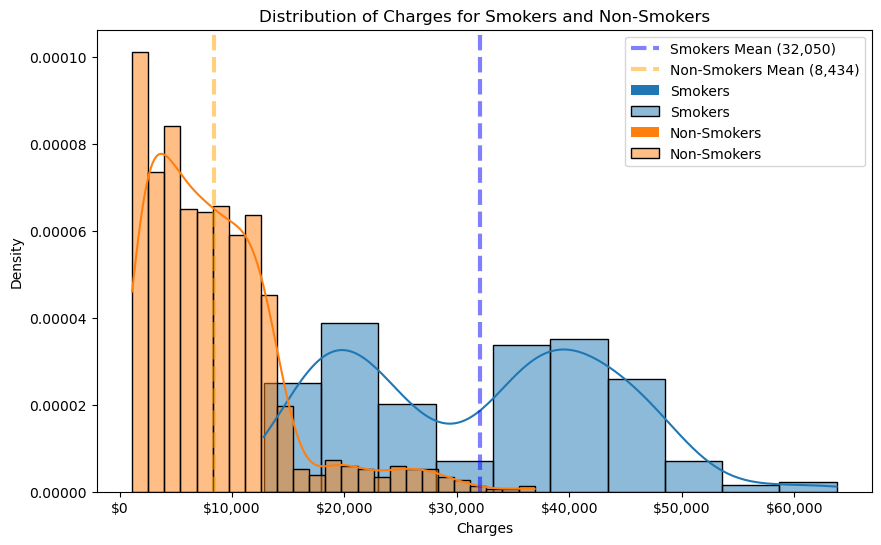

In [6]:
# plotting the distribution of smokers and non-smokers charges and comparing them with a histogram 
fix, ax = plt.subplots(figsize=(10, 6))
sns.histplot(smokers, kde=True, label='Smokers', ax=ax, stat='density')
sns.histplot(non_smokers, kde=True, label='Non-Smokers', ax=ax, stat='density')
ax.xaxis.set_major_formatter('${x:,.0f}')
ax.axvline(smokers.mean(), linestyle='--', label=f'Smokers Mean ({smokers.mean():,.0f})', color='blue', lw=3, alpha=0.5)
ax.axvline(non_smokers.mean(), linestyle='--', label=f'Non-Smokers Mean ({non_smokers.mean():,.0f})', color='orange', lw=3, alpha=0.5)
ax.set_title('Distribution of Charges for Smokers and Non-Smokers')
ax.set_xlabel('Charges')
ax.legend(loc='upper right')
plt.show()


1. State your Null Hypothesis and Alternative Hypothesis.

- [`H0`]: "There is no difference in the average insurance charges between smokers and non-smokers"
- [`H1`]: "Smokers have higher average insurance charges than non-smokers"

2. Select the correct test according to the data type and number of samples.

Since the data above are from different groups, I will perform an indepedent t-test to see the statical difference or if these results are valid due to the random sampling.

3. Test the assumptions of your selected test.

In [7]:
# Testing is theres outliers in the data
zscores_s = stats.zscore(smokers)
zscores_ns = stats.zscore(non_smokers)

# Removing outliers
smokers = smokers[(np.abs(zscores_s) < 3) & (np.abs(zscores_s) > -3)]
non_smokers = non_smokers[(np.abs(zscores_ns) < 3) & (np.abs(zscores_ns) > -3)]

# Checking is theres outliers in the data
zscores_s = stats.zscore(smokers)
zscores_ns = stats.zscore(non_smokers)

outliers_s = abs(zscores_s) > 3
outliers_ns = abs(zscores_ns) > 3

print(f'Outliers in smokers: {outliers_s.sum()}')
print(f'Outliers in non-smokers: {outliers_ns.sum()}')


Outliers in smokers: 0
Outliers in non-smokers: 19


In [8]:
print('Normality Test for Smokers')
print('Smokers:', stats.normaltest(smokers))
print('Normality Test for Non-Smokers')
print('Non-Smokers:', stats.normaltest(non_smokers))

# Printing equal variance test
print('Equal Variance Test')
print(stats.levene(smokers, non_smokers))

Normality Test for Smokers
Smokers: NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)
Normality Test for Non-Smokers
Non-Smokers: NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)
Equal Variance Test
LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [9]:
# Independent t-test with equal_var=False
result = stats.ttest_ind(smokers, non_smokers, equal_var=False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

5. Interpret your p-value and reject or fail to reject your null hypothesis

In [10]:
if result.pvalue < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


6. Show a supporting visulaztion that helps display the result.

<AxesSubplot: xlabel='smoker', ylabel='charges'>

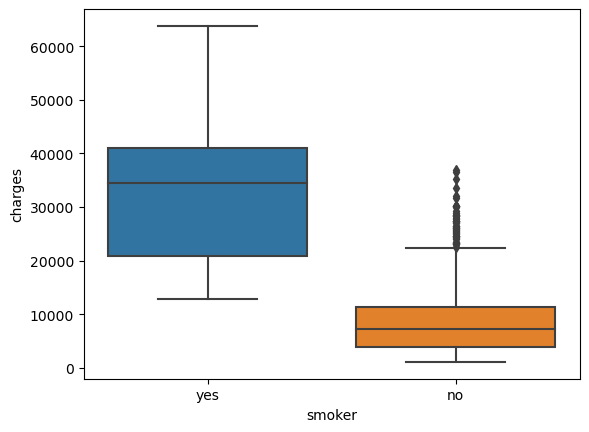

In [11]:
sns.boxplot(x='smoker', y='charges', data=insurance)

# Q2. Are men more likely to smoke than women?

<AxesSubplot: xlabel='smoker', ylabel='count'>

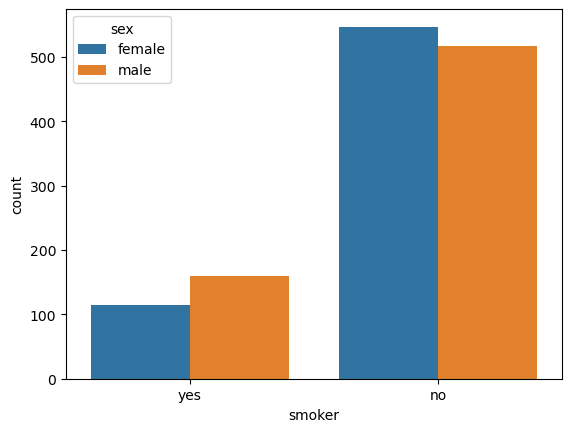

In [14]:
sns.countplot(data=insurance, x='smoker', hue='sex')



1. State your Null Hyothesis and Alternative Hypothesis

- [`H0`] - Men are not, more likely to smoke than women.

- [`H1`] - Men are more likely to smoke, rather than women.

2. Select the correct test according to the data type and number of samples.

Because the data type are `O` we will be using Chi-Squared Test to perform this analysis on this dataset.

3. Test the assumptions of your selected test.

In [15]:
# First we need to calculate the contigency table with pd.crosstab
table = pd.crosstab(insurance['smoker'], insurance['sex'])
table

sex,female,male
smoker,,
no,547,517
yes,115,159


4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [16]:
# Running the Test and Saving the ouput in a variable
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected = result # unpacking the result

In [17]:
# Printing the p-value
print('p-value:', p)
p < 0.05

p-value: 0.006548143503580696


True

5. Interpret your p-value and reject or fail to reject your null hypothesis

In [18]:
if p < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


6. Show a supporting visulaztion that helps display the result.

# Q3. Do different regions have different charges, on average?

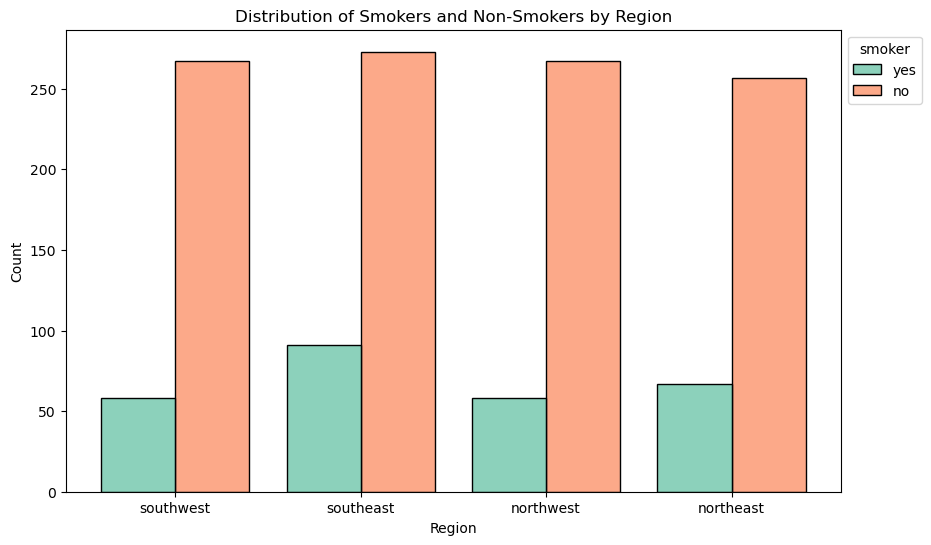

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.histplot(data=insurance, x='region', hue='smoker', multiple='dodge', shrink=0.8, palette='Set2')
sns.move_legend(ax, bbox_to_anchor=(1,1), loc='upper left')
ax.set_title('Distribution of Smokers and Non-Smokers by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Count')
plt.show()

1. State your Null Hypothesis and Alternative Hypothesis